**Loading Libraries**

In [ ]:
#Import Libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import SVG, Image
import tensorflow as tf

**Load dataset**

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Kaggel Competition/train.csv')

In [ ]:
#To split the the sequence of numbers and then store them in a array
#then reshape to (48,48,1) having type 'uint8'i.e values between 0 to 255
img_array = train.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48,1).astype('uint8'))
print(img_array.ndim)
print(img_array.shape)
#Join a sequence of arrays along a new axis. The axis parameter specifies the index of the new axis
#in the dimensions of the result. For example, if axis=0 it will be the first dimension
#img_array=img_array.reshape(len,48,48,1)
img_array = np.stack(img_array, axis=0)
print(img_array.ndim)
print(img_array.shape)

1
(28709,)
4
(28709, 48, 48, 1)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
img_labels = le.fit_transform(train.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(28709, 7)

In [ ]:
#Splitting dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                      test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((22967, 48, 48, 1), (5742, 48, 48, 1), (22967, 7), (5742, 7))

In [ ]:
#Now we will scale the values between 0 to 1 i.e to get grayscale and the shape of the input image data will be 
#changed to (samples, height, width, channels) format by default in ImageDataGenerator
train_datagen = ImageDataGenerator(
					rescale=1./255,      # we multiply the data by the value provided 
					horizontal_flip=True)
train_datagen.fit(X_train)
#train_data = train_datagen.flow(X_train, y_train ,batch_size=25)

val_datagen = ImageDataGenerator(
					rescale=1./255,      # we multiply the data by the value provided 
					horizontal_flip=True)
val_datagen.fit(X_valid)
#val_data = val_datagen.flow(X_valid, y_valid ,batch_size=32)


In [ ]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=512, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(48,48,1),padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=hp.Choice('conv_1_pool', values = [2,4])),
    keras.layers.Dropout(rate = hp.Float('conv_1_dropout', min_value=0.0, max_value=0.5, step=0.05)),

    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=512, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(rate = hp.Float('conv_2_dropout', min_value=0.0, max_value=0.5, step=0.05)),

    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=512, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(rate = hp.Float('conv_3_dropout', min_value=0.0, max_value=0.5, step=0.05)),

    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=512, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(rate = hp.Float('conv_3_dropout', min_value=0.0, max_value=0.5, step=0.05)),

    keras.layers.Flatten(),

    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=512, step=16),
        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = hp.Float('dense_1_dropout', min_value=0.0, max_value=0.5, step=0.05)),

    keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=512, step=16),
        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = hp.Float('dense_2_dropout', min_value=0.0, max_value=0.5, step=0.05)),

    keras.layers.Dense(7, activation='softmax')
  ])
  
  model.compile(optimizer = keras.optimizers.Adam(hp.Float('learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG')),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
  
  return model

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=1f627ab58c8b2925cc74c5afbd39c1fef31bf0b566b7882232e8716ef03f40bb
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=6db6ee89abc3304e43e86c13dce24fb917a110e124ef03812fa856d478d13209
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
# RandomSearch will search for the best parameters
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
# Here we will do 5 different trials. 
tuner_search = RandomSearch(build_model ,
                          objective='val_accuracy',
                          max_trials=3,directory='output',project_name="Project2")

INFO:tensorflow:Reloading Oracle from existing project output/Project2/oracle.json
INFO:tensorflow:Reloading Tuner from output/Project2/tuner0.json


In [ ]:
tuner_search.search(img_array, img_labels,epochs=50,validation_split=0.1)

INFO:tensorflow:Oracle triggered exit


In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 208)       5408      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 208)       832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 208)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 208)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 384)       719232    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 384)       1536      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 384)       0

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 50
opt = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data = val_datagen.flow(X_valid, y_valid, batch_size=batch_size)
    )

Epoch 1/50
717/717 [==============================] - 23s 32ms/step - loss: 1.0672 - accuracy: 0.6544 - val_loss: 3.3038 - val_accuracy: 0.1304
Epoch 2/50
717/717 [==============================] - 23s 32ms/step - loss: 0.8407 - accuracy: 0.7070 - val_loss: 0.7039 - val_accuracy: 0.7626
Epoch 3/50
717/717 [==============================] - 23s 31ms/step - loss: 0.7807 - accuracy: 0.7326 - val_loss: 0.7013 - val_accuracy: 0.7591
Epoch 4/50
717/717 [==============================] - 23s 32ms/step - loss: 0.7389 - accuracy: 0.7468 - val_loss: 0.8745 - val_accuracy: 0.6907
Epoch 5/50
717/717 [==============================] - 23s 32ms/step - loss: 0.6917 - accuracy: 0.7629 - val_loss: 0.6745 - val_accuracy: 0.7743
Epoch 6/50
717/717 [==============================] - 23s 32ms/step - loss: 0.6530 - accuracy: 0.7740 - val_loss: 0.7159 - val_accuracy: 0.7525
Epoch 7/50
717/717 [==============================] - 23s 31ms/step - loss: 0.6250 - accuracy: 0.7844 - val_loss: 0.7794 - val_accuracy:

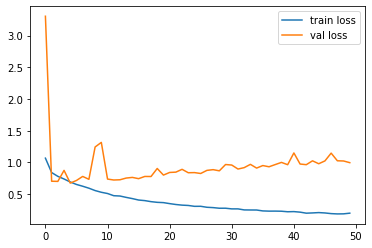

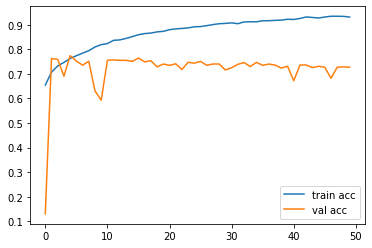

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(opt.history['loss'], label='train loss')
plt.plot(opt.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(opt.history['accuracy'], label='train acc')
plt.plot(opt.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


After tuning our previous model with optimum parameters we oberve that our training accuracy incresed more than 90% after 25 epochs.The validation_accuracy has increased more than 70% in only 50 epochs.

In [ ]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")